# Stopword Analysis

### We used 3 TC (Test Case) on this Project:
1. Zipf Law
2. Mutual Information
3. NLTK Stopword

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#For download Stopwords
#import nltk
#nltk.download('stopwords')

from collections import Counter
#--------------------------------------#
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

## Read the Dataset

In [ ]:
df = pd.read_csv('dataset/web-text-corpus/webtext.csv')

In [ ]:
df

In [ ]:
df.info()

### Drop Missing Value on Rows

In [ ]:
no_null_df = df.dropna()

In [ ]:
no_null_df.info()

In [ ]:
cnt = Counter()
dictionary_domain = {}
for domain in no_null_df['domain']:
    cnt[domain] += 1

In [ ]:
cnt

### We take 30 samples/sentences which including 15 data on Firefox class, 15 data on Overheard class

In [ ]:
df_sample_firefox = no_null_df[no_null_df['domain'] == 'firefox'].iloc[:15,:]
df_sample_overheard = no_null_df[no_null_df['domain'] == 'overheard'].iloc[:15,:]
df_sample = pd.concat([df_sample_firefox, df_sample_overheard])

In [ ]:
df_sample

In [ ]:
df_sample.reset_index(drop=True)

## Preprocessing

### Case Folding

In [ ]:
prepro_df = df_sample.copy()

In [ ]:
prepro_df['text'] = prepro_df['text'].str.lower()

### Remove Punctuations, HTML, URL

In [ ]:
def cleansing(document):
    #Define the Regex
    regex_html = '</?.*/?>'
    regex_url = '(https?://)|(https?:\/\/)?(www\.)?([-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*))'
    regex_punc = '[!\(\)-\[\]{};:"\'\,<>\./\?@#$%^&*_~]'
    regex_space = '\s{2,}'
    
    #Replace if match with Regex pattern
    document['text'] = document['text'].str.replace(regex_html, ' ')
    document['text'] = document['text'].str.replace(regex_url, ' ')
    document['text'] = document['text'].str.replace(regex_punc, '')
    document['text'] = document['text'].str.replace(regex_space, ' ')
    
    #Reset index
    document = document.reset_index(drop=True)
    
    return document

In [ ]:
cleansing_df = cleansing(prepro_df)

In [ ]:
cleansing_df

In [ ]:
df_sample

### Split the Training and Testing Data

In [ ]:
df_x = cleansing_df[['text']]
df_y = cleansing_df[['domain']]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

In [ ]:
X_valid

In [ ]:
prepro_df.info()

### Remove Stopwords
Some references I found according to Stopwords Analysis:
1. https://www.sciencedirect.com/science/article/pii/S1877050914013799
2. https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html
3. https://medium.com/@jasoncrease/zipf-54912d5651cc
4. https://medium.com/@devalshah1619/a-mysterious-law-so-simple-and-yet-so-universal-aa9f1c8903d1
5. https://www.slideshare.net/Staano/stopwords

## Using Zipf Law

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
X = vectorizer.fit_transform(X_train['text'])

In [ ]:
print(vectorizer.get_feature_names())
print('\n{} terms'.format(len(vectorizer.get_feature_names())))

In [ ]:
X.shape

### Create Dataframe from TF Matrix

In [ ]:
df_tf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
df_tf 

### Count total occurences of each Term in Document

In [ ]:
def count_idf(document):
    #init variable
    term_idf = []
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(document)
    term = vectorizer.get_feature_names()
    term_array = X.toarray()
    
    #count IDF (Inverse Document Frequency) for each Term
    for i in range(len(term)):
        df = sum([1 for tf in term_array[:, i] if tf >= 1])
        idf = np.log10(len(document) / df)
        term_idf.append((term[i], idf))
    return term_idf

In [ ]:
def count_occurences(document):
    #init variable
    term_occurences = []
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(document)
    term = vectorizer.get_feature_names()
    term_array = X.toarray()
    
    #count total term on each doc
    for i in range(len(term)):
        count_term = sum(term_array[:, i])
        term_occurences.append((term[i], count_term))
    return term_occurences

In [ ]:
occurences = count_occurences(X_train['text'])

In [ ]:
idf_each_term = count_idf(X_train['text'])

In [ ]:
idf_each_term.sort(reverse=True, key=lambda x: x[1])

In [ ]:
idf_each_term

In [ ]:
occurences

In [ ]:
occurences.sort(reverse=True, key=lambda x: x[1])

In [ ]:
key_occurences = [ item[0] for item in occurences]
value_occurences = [ item[1] for item in occurences]

In [ ]:
key_occurences

In [ ]:
def plot_zipf(terms: [], freq: []):
    fig = plt.figure(figsize=(40,20))
    plt.plot(terms, freq)
    plt.xticks(terms, rotation='vertical')
    plt.xlabel('Terms')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
plot_zipf(key_occurences, value_occurences)

In [ ]:
def create_dataframe_tuple(list_of_tuple, columns):
    list_of_tuple.sort(reverse=True, key=lambda x: x[1])
    df_ = pd.DataFrame(list_of_tuple, columns=columns)
    return df_

In [ ]:
occurences_df = create_dataframe_tuple(occurences, columns=['terms', 'freq'])

In [ ]:
idf_df = create_dataframe_tuple(list_of_tuple=idf_each_term, columns=['terms', 'idf'])

### Based on Paper....
There are several methods on removing Stopwords, in Zipf's Law (Z-Methods):
Three stopword creation methods are used in addition to the classic stoplist. This includes removing most frequent words (TF-High), removing words that occur once, i.e., singleton words (TF1), and removing words with low inverse document frequency (IDF) (Jashanjot, Buttar, 2018).

### Zipf Law

In [ ]:
def filter_freq_zipf(dataframe_tf, dataframe_idf, threshold_idf):
    most_freq = max(dataframe_tf['freq'])
    #singleton_word = 1
    filter_tf = dataframe_tf[(dataframe_tf['freq'] == most_freq)] #| (dataframe_tf['freq'] == singleton_word)]
    filter_idf = dataframe_idf[(dataframe_idf['idf'] <= threshold_idf)]
    print(filter_tf)
    print(filter_idf)
    stopwords = np.concatenate((filter_tf['terms'], filter_idf['terms']))
    return list(set(stopwords))

In [ ]:
stopword_zipf = filter_freq_zipf(occurences_df, idf_df, 1)

In [ ]:
stopword_zipf

### Mutual Information

In [ ]:
def mutual_info_feature(document):
    mi = []
    vect = CountVectorizer()
    X = vect.fit_transform(document[0]['text'])
    terms = vect.get_feature_names()
    mutual_term = mutual_info_classif(X=X, y=document[1]['domain'])
    for term, mutual in zip(terms, mutual_term):
        mi.append((term, mutual))
    return mi

In [ ]:
mutual_information = mutual_info_feature([X_train, y_train])

In [ ]:
mi_df = pd.DataFrame(mutual_information, columns=['terms', 'mutual information'])

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(mi_df)

In [ ]:
#Because minimum MI is relative value, we used rank to get the terms with miniumum MI
rank = 7

In [ ]:
#filter the most minimum Mutual Information on a Sorted DF
def filter_minimum_mi(tuple_of_list, rank):
    tuple_of_list.sort(reverse=False, key=lambda x: x[1])
    df_ = pd.DataFrame(tuple_of_list, columns=['terms', 'mutual information'])
    return df_.iloc[:rank+1, :]

In [ ]:
filter_minimum_mi(mutual_information, rank)

### Remove Stopwords using Zipf and Mutual Information

In [ ]:
def remove_stopwords(stopword_list, document):
    print('\nOriginal Doc\n', document)
    
    split_space = document['text'].apply(lambda x: x.split())
    print('\nAfter Split by Space\n', split_space)
    
    stopword_removal = split_space.apply(lambda x: [ item for item in x if item not in stopword_list ])    
    print('\nAfter Removing Stopwords\n', stopword_removal)
    
    join_space = stopword_removal.apply(lambda x: ' '.join(x))
    print('\nAfter Joining by Space\n', join_space)
    
    stopword_remove_df = pd.DataFrame(join_space)
    return stopword_remove_df

In [ ]:
stopwords_df_zipf = remove_stopwords(stopword_zipf, X_train)

In [ ]:
stopword_mi = filter_minimum_mi(tuple_of_list=mutual_information, rank=rank)

In [ ]:
stopword_mi

In [ ]:
stopwords_df_mi = remove_stopwords(list(stopword_mi['terms']), X_train)

In [ ]:
stopwords_df_mi

In [ ]:
stopwords_df_nltk = remove_stopwords(nltk_stopwords, X_train)

In [ ]:
def generate_term(document):
    cv = CountVectorizer()
    X_st = cv.fit_transform(document['text'])
    return cv.get_feature_names()

In [ ]:
generate_term(stopwords_df_zipf)

In [ ]:
generate_term(stopwords_df_mi)

## Ranking Evaluation

In this section, we compute the Cosine Similarity between Query and Corpus

### We have to preprocess the Validation Data first

In [ ]:
cleansing(document=X_valid)

### Dataframe Results after Removing Stopwords using Mutual Information and Zipf Law

In [ ]:
nltk_stopwords = stopwords.words('english')

In [ ]:
nltk_stopwords

### Query

### NLTK Stopwords

In [ ]:
valid_remove_nltk = remove_stopwords(nltk_stopwords, X_valid)

In [ ]:
valid_stopwords_df_nltk = pd.concat([valid_remove_nltk, y_valid], axis=1)

In [ ]:
valid_stopwords_df_nltk

### Mutual Information

In [ ]:
list(stopword_mi['terms'])

In [ ]:
valid_remove_mi = remove_stopwords(list(stopword_mi['terms']), X_valid)

In [ ]:
valid_stopwords_df_mi = pd.concat([valid_remove_mi, y_valid], axis=1)

In [ ]:
valid_stopwords_df_mi

### Zipf Law

In [ ]:
stopword_zipf

In [ ]:
valid_remove_zipf = remove_stopwords(stopword_zipf, X_valid)

In [ ]:
valid_stopwords_df_zipf = pd.concat([valid_remove_zipf, y_valid], axis=1)

In [ ]:
valid_stopwords_df_zipf

### Corpus

### NLTK Stopwords

In [ ]:
stopwords_df_nltk = pd.concat([stopwords_df_nltk, y_train], axis=1)

In [ ]:
stopwords_df_nltk

### Mutual Information

In [ ]:
stopwords_df_mi = pd.concat([stopwords_df_mi, y_train], axis=1)

In [ ]:
stopwords_df_mi

### Zipf Law

In [ ]:
stopwords_df_zipf = pd.concat([stopwords_df_zipf, y_train], axis=1)

In [ ]:
stopwords_df_zipf

### Concat the Corpus and Query into 1 Dataframe first to Compute the Cosine Similarity

I am using this reference while computing Cosine Similarity:
* http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/

In [ ]:
def compute_cossim(document_corpus, document_query):
    cossim_list = []
    for i in range(len(document_query)):
        
        #Add the query to the Corpus (will be the last index)
        appended_document = document_corpus.append(document_query.iloc[i])
        print('\nAfter Append Query to Corpus\n', appended_document)
        
        cv_cossim = CountVectorizer()
        tf_matrix = cv_cossim.fit_transform(appended_document['text'])
        
        #-1 index means we want to compute cossim between the Query (the last data because appended) and Corpus
        cossim = cosine_similarity(tf_matrix[-1], tf_matrix)
        
        print('Cosine Similarity-', (i+1) ,'th\n', cossim, '\n')
        print(appended_document.reset_index(drop=True))
        
        #Concat the Appended Document with Cossim Value (Ravel is for flatten the 2d into 1d array)
        cossim_df = pd.DataFrame(cossim.ravel(), columns=['cossim'])
        concat_cossim = pd.concat([appended_document.reset_index(drop=True), cossim_df], axis=1)
        cossim_list.append(concat_cossim)
        print('\nAfter concat with Cossim\n', concat_cossim)
        print('='*100)
        
    return cossim_list

In [ ]:
def define_relevant(list_of_cosine_similarity):
    cossim_relevant_not = []
    for cossim in list_of_cosine_similarity:
        query_label = cossim.iloc[-1]['domain']
        corpus_label = cossim.iloc[:-1]['domain']
        relevant_or_not = [ 'Relevant' if item == query_label else 'Not Relevant' for item in corpus_label ]
        ron_df = pd.DataFrame(relevant_or_not, columns=['Relevant/Not Relevant'])
        print('\nRelevant/Not Dataframe\n', ron_df)
        concat_ = pd.concat([cossim, ron_df], axis=1)
        
        #sort Cossim Descending from highest value to lowest value
        concat_ = concat_.sort_values(by='cossim', ascending=False)
        print('\nConcat with Relevant / Not \n', concat_)
        cossim_relevant_not.append(concat_)
        
    return cossim_relevant_not

### Mutual Information

In [ ]:
cossim_using_mi = compute_cossim(document_corpus=stopwords_df_mi, document_query=valid_stopwords_df_mi)

In [ ]:
cossim_using_mi

In [ ]:
relevant_not_mi_ = define_relevant(cossim_using_mi)

### NLTK

In [ ]:
cossim_using_nltk = compute_cossim(document_corpus=stopwords_df_nltk, document_query=valid_stopwords_df_nltk)

In [ ]:
relevant_not_nltk_ = define_relevant(cossim_using_nltk)

### Zipf Law

In [ ]:
cossim_using_zipf = compute_cossim(document_corpus=stopwords_df_zipf, document_query=valid_stopwords_df_zipf)

In [ ]:
relevant_not_zipf_ = define_relevant(cossim_using_zipf)

### In this code we used 6 queries, which every query included with the Corpus.
Below are the examples of Query using MI on Stopword removal

In [ ]:
relevant_not_mi_[0]

In [ ]:
relevant_not_mi_[1]

In [ ]:
relevant_not_mi_[2]

In [ ]:
relevant_not_mi_[3]

In [ ]:
relevant_not_mi_[4]

In [ ]:
relevant_not_mi_[5]

### Using Precision@K

In [ ]:
def precision_at_k(document, k: int):
    precision_list = []
    for idx, each_doc in enumerate(document):
        print('Query ', idx+1, ': ', each_doc.iloc[0]['text'], '\n')
        #we add it with 1 when every document is relevant, and start the loop from 1 till k to avoid the Query which located at first index.
        result = [ each_doc.iloc[i]['text'] for i in range(1, k+1) if each_doc.iloc[i]['Relevant/Not Relevant'] == 'Relevant' ]

        #we print the Relevant Documents at K
        print('Relevant Documents\n')
        for i, item in enumerate(result):
            print(i+1, ')', item)
        print('\nPrecision@', k, '= ', len(result), '/', k, '= ', len(result)/k)
        print('='*100, '\n')
        precision_list.append(len(result)/k)
    plot_precision_at_k(precision_list=precision_list)
    return

In [ ]:
def plot_precision_at_k(precision_list):
    query_text = []
    fig = plt.figure(figsize=(10,10))
    for i in range(len(precision_list)):
        query_text.append('Query '+str(i+1))
    y_pos = np.arange(len(precision_list))
    plt.bar(y_pos, precision_list, align='center')
    plt.xticks(y_pos , query_text)
    plt.show()

### Precision@K using NLTK for Removing Stopwords

In [ ]:
precision_at_k(relevant_not_nltk_, k=5)

### Precision@K using Mutual Information for Removing Stopwords

In [ ]:
precision_at_k(relevant_not_mi_, k=5)

### Precision@K using Zipf Law for Removing Stopwords

In [ ]:
precision_at_k(relevant_not_zipf_, k=5)

### Mean Average Precision

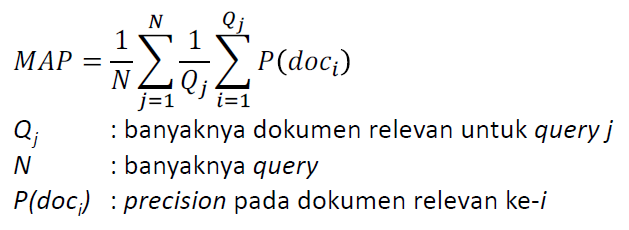

In [ ]:
def mean_average_precision(document):
    map_list = []
    precision_list = []
    #loop i index for dataframe
    for i in range(len(document)):
        #we reset the Relevant Doc count to be zero every Loop on Dataframe
        countRelevant = 0
        
        #loop j index for every row in dataframe
        for j in range(len(document[i])):
            #Checks if every document is relevant with the Query or Not
            if document[i].iloc[j]['Relevant/Not Relevant'] == 'Relevant':
                countRelevant+=1
                precision = countRelevant/j
            else:
                precision = 0
                
            #Precision value on every document (on each Dataframe) will be append to this List
            precision_list.append(precision)
            
        precision_df = pd.DataFrame(precision_list, columns=['precision'])
        concat_with_precision = pd.concat([document[i].reset_index(drop=True), precision_df], axis=1)
        precision_list.append(concat_with_precision)
        
        map_each_query = np.mean(concat_with_precision['precision'])
        print('Query', (i+1), ': ', document[i].iloc[0]['text'])
        print('Average Precision from Query', i, '= ', map_each_query, '\n')
        map_list.append(map_each_query)
        
        #Clear the Precision List before going to next Loop on Dataframe that consists of Query and Corpus
        precision_list.clear()
    
    mean_average_precision_all_query = np.mean(map_list)
    return mean_average_precision_all_query

### MAP using NLTK for Removing Stopwords

In [ ]:
map_nltk = mean_average_precision(document=relevant_not_nltk_)
map_nltk

### MAP using Mutual Information for Removing Stopwords

In [ ]:
map_mi = mean_average_precision(document=relevant_not_mi_)
map_mi

### MAP using Zipf Law for Removing Stopwords

In [ ]:
map_zipf = mean_average_precision(document=relevant_not_zipf_)
map_zipf

### Plot them

In [ ]:
map_all_tc = np.array([map_mi, map_zipf, map_nltk])
test_cases = ['Mutual Information', 'Zipf Law', 'NLTK']
y_pos = np.arange(len(map_all_tc))

fig = plt.figure(figsize=(10,10))
plt.title('MAP Comparison among Several Test Cases')
plt.xlabel('Test Cases')
plt.ylabel('Mean Average Precision')
plt.bar(y_pos, map_all_tc, align='center', alpha=0.8)
plt.xticks(y_pos, test_cases)
plt.show()